In [1]:
import sys
print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [2]:
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2) 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense,Dropout
from keras.layers.recurrent import LSTM,GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### Data Preprocessing

In [4]:
# Loading the dataset
df = pd.read_csv('GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [5]:
df['Date']= pd.to_datetime(df['Date'])

In [6]:
# df.set_index("Date",inplace=True)
#df = df.iloc[:4122,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4122,2021-01-04,1757.540039,1760.650024,1707.849976,1728.239990,1728.239990,1901900
4123,2021-01-05,1725.000000,1747.670044,1718.015015,1740.920044,1740.920044,1145300
4124,2021-01-06,1702.630005,1748.000000,1699.000000,1735.290039,1735.290039,2602100
4125,2021-01-07,1740.060059,1788.400024,1737.050049,1787.250000,1787.250000,2265000
4126,2021-01-08,1787.979980,1809.839966,1773.535034,1807.209961,1807.209961,2050600


In [7]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.999752
High         0.999869
Low          0.999889
Close        1.000000
Adj Close    1.000000
Volume      -0.531202
Name: Adj Close, dtype: float64

In [8]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.127000e+03
mean     6.764648e+06
std      7.925282e+06
min      7.900000e+03
25%      1.689050e+06
50%      4.073300e+06
75%      8.662900e+06
max      8.254150e+07
Name: Volume, dtype: float64


In [9]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [10]:
#model.summary()

In [11]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    Y_hat = sc.inverse_transform(Y_hat)
    Y_test = sc.inverse_transform(Y_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat,multioutput='uniform_average')
    return mse, rmse, r, Y_test, Y_hat

In [12]:
# # Plotting the predictions
# def plot_data(Y_test,Y_hat):
#     plt.plot(Y_test,c = 'y')
#     plt.plot(Y_hat,c = 'g')
#     plt.xlabel('Day')
#     plt.ylabel('Price')
#     plt.title('Stock Prediction Graph using Multivariate-LSTM model')
#     plt.legend(['Actual','Predicted'],loc = 'lower right')
#     plt.show()

In [13]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Model Building

In [14]:
# Extracting the series
series = df[['Date','Open','High','Low','Adj Close']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(4127, 5)
           Date         Open         High          Low    Adj Close
4122 2021-01-04  1757.540039  1760.650024  1707.849976  1728.239990
4123 2021-01-05  1725.000000  1747.670044  1718.015015  1740.920044
4124 2021-01-06  1702.630005  1748.000000  1699.000000  1735.290039
4125 2021-01-07  1740.060059  1788.400024  1737.050049  1787.250000
4126 2021-01-08  1787.979980  1809.839966  1773.535034  1807.209961


In [15]:
# Train Val Test Split
#sert = series[series['Date'] <= '2019-12-31']
#future = series[(series['Date'] > '2019-12-31')]
# val_data = series.loc[151:201]
# test_data = series.loc[202:250]
# print(train_data.shape,val_data.shape,test_data.shape)
#print(sert.shape,future.shape)

In [16]:
# Normalisation
sc = MinMaxScaler()
main_data = sc.fit_transform(series.drop(['Date'],axis=1))
# test_data = sc.fit_transform(serte.drop(['Date'],axis=1))
# series_sc = np.column_stack((series_sc,temp))
print(main_data.shape)
# print(test_data.shape)

(4127, 4)


In [17]:
train_data = main_data[:int(len(main_data)*0.8),:]
test_data = main_data[int(len(main_data)*0.8):,:]
train_data.shape,test_data.shape

((3301, 4), (826, 4))

In [18]:
# Number of past days to be taken
timesteps=3

In [19]:
X_train = []
Y_train = []
for i in range(len(train_data)-timesteps-1):
    X_train.append(train_data[i:i+timesteps,:3])
    Y_train.append((train_data[i+timesteps,3]))
X_train,Y_train = np.array(X_train),np.array(Y_train)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 3)
Y_train =Y_train.reshape(Y_train.shape[0], 1)
print('shape of X_train and Y_train',X_train.shape,Y_train.shape)

shape of X_train and Y_train (3297, 3, 3) (3297, 1)


In [20]:
X_test = []
Y_test = []

# Loop for testing data
for i in range(len(test_data)-timesteps-1):
    X_test.append(test_data[i:i+timesteps,:3])
    Y_test.append((test_data[i+timesteps,3]))
X_test,Y_test = np.array(X_test),np.array(Y_test)
X_test =X_test.reshape(X_test.shape[0],X_test.shape[1] , 3)
Y_test =Y_test.reshape(Y_test.shape[0], 1)
print(X_test.shape,Y_test.shape)

(822, 3, 3) (822, 1)


Epoch 1/20
83/83 [==============================] - 5s 27ms/step - loss: 0.0110 - val_loss: 0.0131
Epoch 2/20
83/83 [==============================] - 2s 21ms/step - loss: 7.0725e-04 - val_loss: 8.1239e-05
Epoch 3/20
83/83 [==============================] - 2s 21ms/step - loss: 2.2056e-04 - val_loss: 1.3628e-04
Epoch 4/20
83/83 [==============================] - 2s 22ms/step - loss: 2.1675e-04 - val_loss: 1.5861e-04
Epoch 5/20
83/83 [==============================] - 2s 19ms/step - loss: 1.5997e-04 - val_loss: 2.0028e-04
Epoch 6/20
83/83 [==============================] - 2s 20ms/step - loss: 1.6096e-04 - val_loss: 2.4985e-04
Epoch 7/20
83/83 [==============================] - 2s 21ms/step - loss: 1.6702e-04 - val_loss: 1.2309e-04
Epoch 8/20
83/83 [==============================] - 2s 21ms/step - loss: 1.4385e-04 - val_loss: 2.6977e-04
Epoch 9/20
83/83 [==============================] - 2s 22ms/step - loss: 1.3635e-04 - val_loss: 1.8147e-04
Epoch 10/20
83/83 [==========================

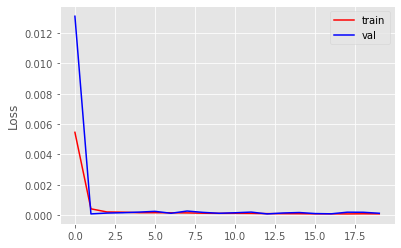

In [21]:
#Build and train the model

# Adding Layers to the model
model = Sequential()
model.add(GRU(units=50,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,activation='relu'))
model.add(Dropout(0.2))
# model.add(GRU(units=50,return_sequences = True,activation='relu'))
# model.add(Dropout(0.2))        
# model.add(LSTM(units=50,activation='relu',return_sequences=True))
# model.add(Dropout(0.2))
model.add(GRU(units=50,return_sequences = True,activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,activation='relu',return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=50,activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(50))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adamax', loss = 'mean_squared_error')
#print(model.summary())

# Training the data
history = model.fit(X_train,Y_train,epochs = 20,batch_size = 32,validation_split=0.2,verbose = 1, callbacks=callbacks_list)
# model.reset_states()
plot_error(history.history['loss'],history.history['val_loss'])

In [22]:
y_hat = model.predict(X_train)
mse = mean_squared_error(Y_train,y_hat)
rmse = sqrt(mse)
r = r2_score(Y_train,y_hat)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

MSE = 4.865188654832728e-05
RMSE = 0.006975090432985603
R-Squared Score = 0.996850218479801


In [23]:
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test,y_pred)
rmse = sqrt(mse)
r = r2_score(Y_test,y_pred)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

MSE = 0.0004349418170689183
RMSE = 0.020855258738958823
R-Squared Score = 0.9669062847642221


In [24]:
a = np.zeros(((len(y_pred)),3))

In [25]:
y_pred = np.append(a,y_pred,axis=1)
Y_test = np.append(a,Y_test,axis=1)

In [26]:
y_pred = sc.inverse_transform(y_pred)
Y_test = sc.inverse_transform(Y_test)

In [ ]:
# mse, rmse, r2_value,true,predicted = evaluate_model(model,train_data,timesteps)
# print('MSE = {}'.format(mse))
# print('RMSE = {}'.format(rmse))
# print('R-Squared Score = {}'.format(r2_value))

In [ ]:
# mse, rmse, r2_value,true,predicted = evaluate_model(model,test_data,timesteps)
# print('MSE = {}'.format(mse))
# print('RMSE = {}'.format(rmse))
# print('R-Squared Score = {}'.format(r2_value))

In [ ]:
# model.save('Stock_try.h5')

In [27]:
temp = pd.DataFrame(Y_test,columns=['','','','Adj Close'])
temp2 = pd.DataFrame(y_pred,columns=['','','','Adj Close'])

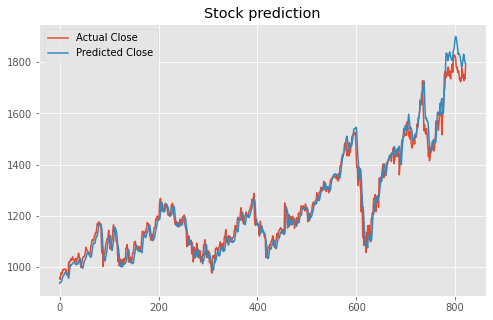

In [28]:
plt.figure(figsize=(8,5))
plt.title("Stock prediction")
plt.plot(temp['Adj Close'],label='Actual Close')
plt.plot(temp2['Adj Close'],label='Predicted Close')
# plt.plot(temp['High'],label='Actual High')
# plt.plot(temp2['High'],label='Predicted High')
# plt.plot(temp['Low'],label='Actual Low')
# plt.plot(temp2['Low'],label='Predicted Low')
plt.legend()

In [45]:
past_days = 3

In [54]:
t_df = series.drop(['Date'],axis=1)

,Open,High,Low,Adj Close
4124,1702.630005,1748.000000,1699.000000,1735.290039
4125,1740.060059,1788.400024,1737.050049,1787.250000
4126,1787.979980,1809.839966,1773.535034,1807.209961


In [55]:
x_input = t_df.iloc[-past_days:,:3]

In [56]:
x_input = sc.fit_transform(x_input)
x_input = x_input.reshape(1,x_input.shape[0],x_input.shape[1])
x_input.shape

(1, 3, 3)

In [57]:
yhat = model.predict(x_input, verbose=1)
a = np.zeros((1,2))

1/1 [==============================] - 0s 14ms/step


In [58]:
a

array([[0., 0.]])

In [61]:
sc.inverse_transform(np.append(a,yhat,axis=1))[:,2]

array([1725.01693456])

In [ ]:
# sub_df = future.set_index(['Date'])
# sub1 = sub_df.iloc[:future_days,:]

In [ ]:
# ind = sub1.index

In [ ]:
# output = pd.DataFrame(lst_output,columns=['Pred Adj Close'])
# output = output.set_index(ind)
# sub_df.append(output,ignore_index=True,)

In [ ]:
# pd.merge(sub1,output,how='left',left_index=True,right_index=True)

,Adj Close,Pred Adj Close
Date,,
2020-01-02,1367.369995,1343.676147
2020-01-03,1360.660034,1343.137573
2020-01-06,1394.209961,1342.672974
2020-01-07,1393.339966,1342.274170
2020-01-08,1404.319946,1341.913818
2020-01-09,1419.829956,1341.570679
2020-01-10,1429.729980,1341.232666
2020-01-13,1439.229980,1340.896606
2020-01-14,1430.880005,1340.558838
